In [1]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'miRNA_plot',
        root = '..'
    )

Read miRNA targets

In [2]:
from pathlib import Path
import pandas as pd
import pyranges as pr
from tqdm import tqdm

gr_targets = dict()

for i in tqdm(snakemake.input['targets']):
    name = Path(i).stem.replace('_targets_counts_exp', '')
    gr_targets[name] = pr.read_bed(i)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87/87 [00:06<00:00, 12.59it/s]


Count number of miRNA target per cell

In [5]:
df_counts = list()

for name, gr in gr_targets.items():   
    df = gr.df

    df_counts.append({
        'sample': name,
        'count': df.shape[0],
        'exp_count': df[df['ThickEnd'] != '.'].shape[0]
    })

df_counts = pd.DataFrame(df_counts)

<AxesSubplot:xlabel='value', ylabel='sample'>

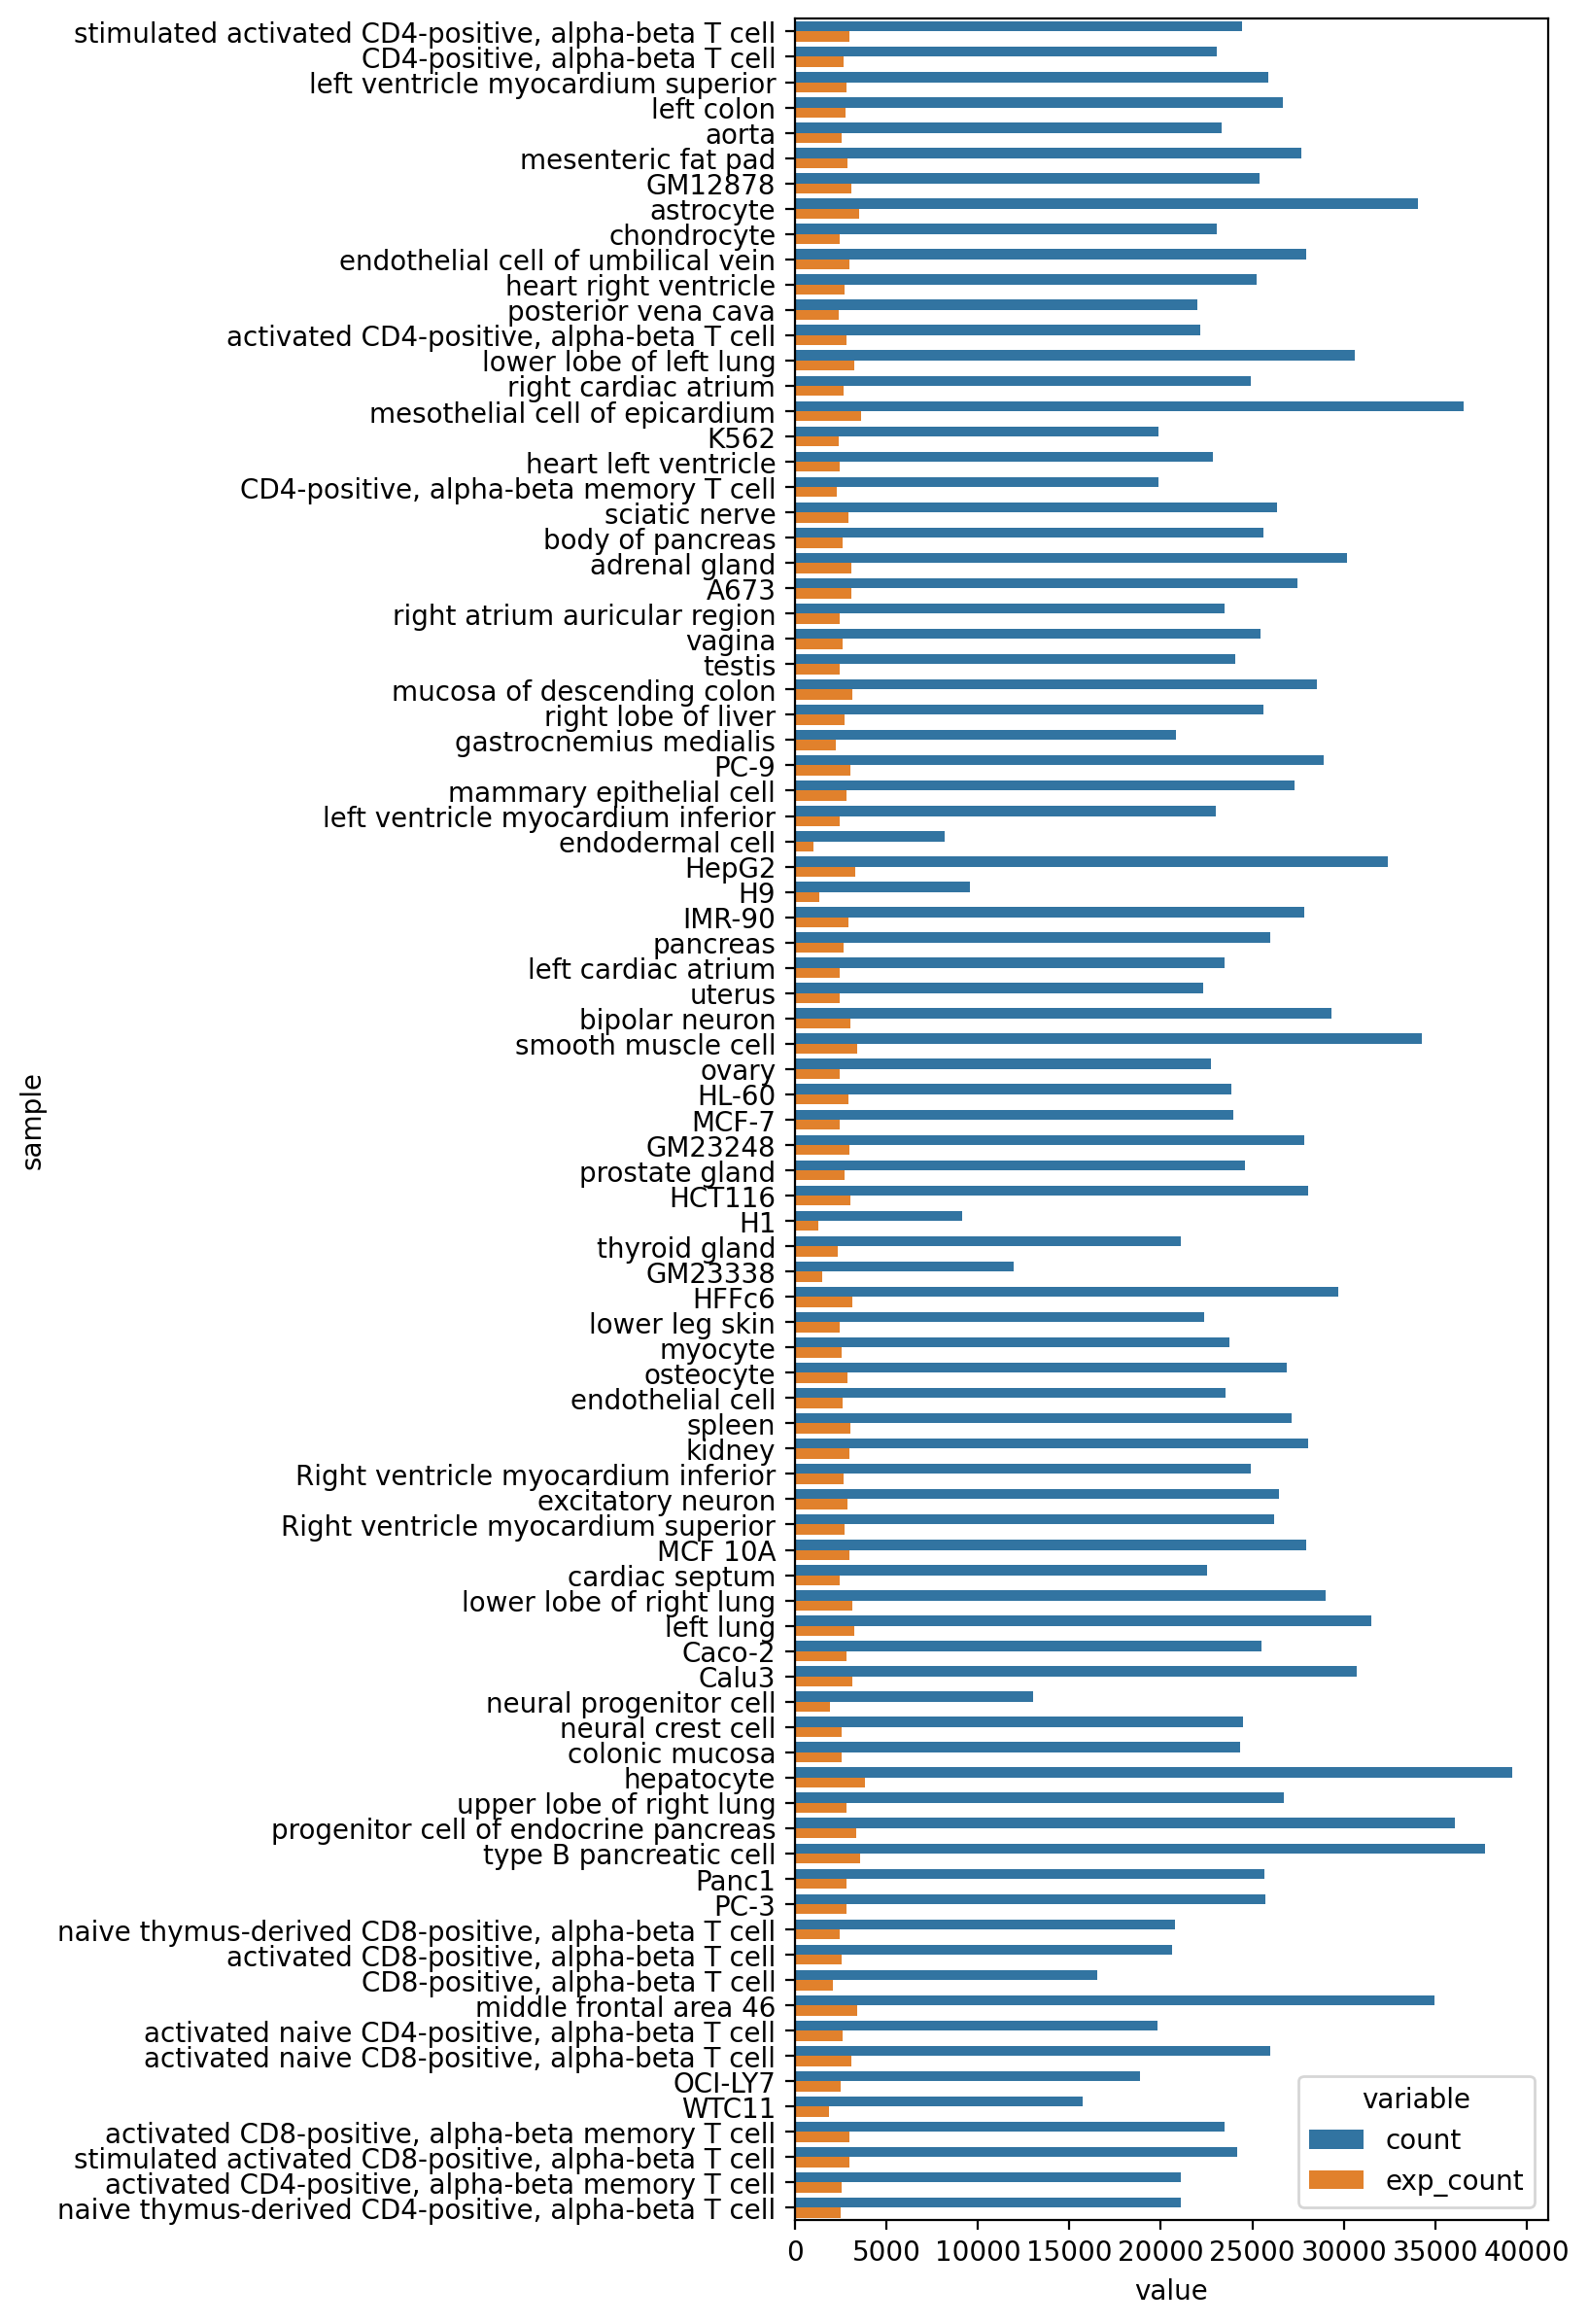

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 15), dpi=200)

sns.barplot(y="sample", x="value", hue="variable", data=df_counts.melt(id_vars='sample'))

Read transcriptome annotation

In [3]:
import pyranges as pr

gr_gtf = pr.read_gtf(snakemake.input['gtf'])

In [4]:
gr_transcript = gr_gtf[gr_gtf.Feature == 'transcript']
gr_protein_coding = gr_transcript[gr_transcript.transcript_type == 'protein_coding']
gr_nmd = gr_transcript[gr_transcript.transcript_type == 'nonsense_mediated_decay']

Transcript and gene expression counts

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_counts = pd.read_csv(snakemake.input['counts'], sep='\t')
df_counts[df_counts['transcript_id'].isin(set(gr_transcript.transcript_id))]

df_gene_count = df_counts[['gene_id', 'transcript_id']].set_index('gene_id').join(
    df_counts.groupby('gene_id').sum()).reset_index()

df_counts = df_counts.set_index('transcript_id')
df_gene_count = df_gene_count.set_index('transcript_id')

In [105]:
celline = 'K562' #  GM12878

In [106]:
df_counts.columns

Index(['gene_id', 'A673_0h', 'A673_2h', 'A673_6h', 'Caco2_0h', 'Caco2_2h',
       'Caco2_6h', 'Calu3_0h', 'Calu3_2h', 'Calu3_6h', 'GM12878_0h',
       'GM12878_2h', 'GM12878_6h', 'HCT116_0h', 'HCT116_2h', 'HCT116_6h',
       'HepG2_0h', 'HepG2_2h', 'HepG2_6h', 'HMEC_0h', 'HMEC_2h', 'HMEC_6h',
       'HUVEC_0h', 'HUVEC_2h', 'HUVEC_6h', 'IMR90_0h', 'IMR90_2h', 'IMR90_6h',
       'K562_0h', 'K562_2h', 'K562_6h'],
      dtype='object')

In [107]:
sample_cols = [f'{celline}_0h', f'{celline}_2h', f'{celline}_6h']

df_usage = (df_counts[sample_cols] / df_gene_count[sample_cols]).join(df_counts[['gene_id']])

In [108]:
# _gr_target = gr_targets[celline][gr_targets[celline].ThickStart != -1]
# _gr_target = _gr_target[_gr_target.Score > 10]
# gr_sample = gr_transcript.join(_gr_target)

In [109]:
df_usage = df_usage[(df_gene_count[f'{celline}_0h'] > 200)]
df_usage = df_usage[(df_counts[f'{celline}_0h'] > 50)]

# df_usage = df_usage[df_usage['K562_0h'] > 0.3].fillna(0)
# df_usage = df_usage[df_counts['gene_id'].isin(target_genes)]

/tmp/ipykernel_8786/2749035989.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_usage = df_usage[(df_gene_count[f'{celline}_0h'] > 200)]
/tmp/ipykernel_8786/2749035989.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_usage = df_usage[(df_counts[f'{celline}_0h'] > 50)]


In [110]:
df_usage = df_usage[df_usage.index.isin(set(gr_protein_coding.transcript_id).union(gr_nmd.transcript_id))]

In [111]:
df_usage['NMD'] = df_usage.index.isin(set(gr_nmd.transcript_id))

In [112]:
df_usage['NMD'].sum()

472

In [113]:
df_usage[f'{celline}_2h_dif'] = df_usage[f'{celline}_2h'] - df_usage[f'{celline}_0h']
df_usage[f'{celline}_6h_dif'] = df_usage[f'{celline}_6h'] - df_usage[f'{celline}_0h']

<AxesSubplot:xlabel='K562_0h', ylabel='K562_6h'>

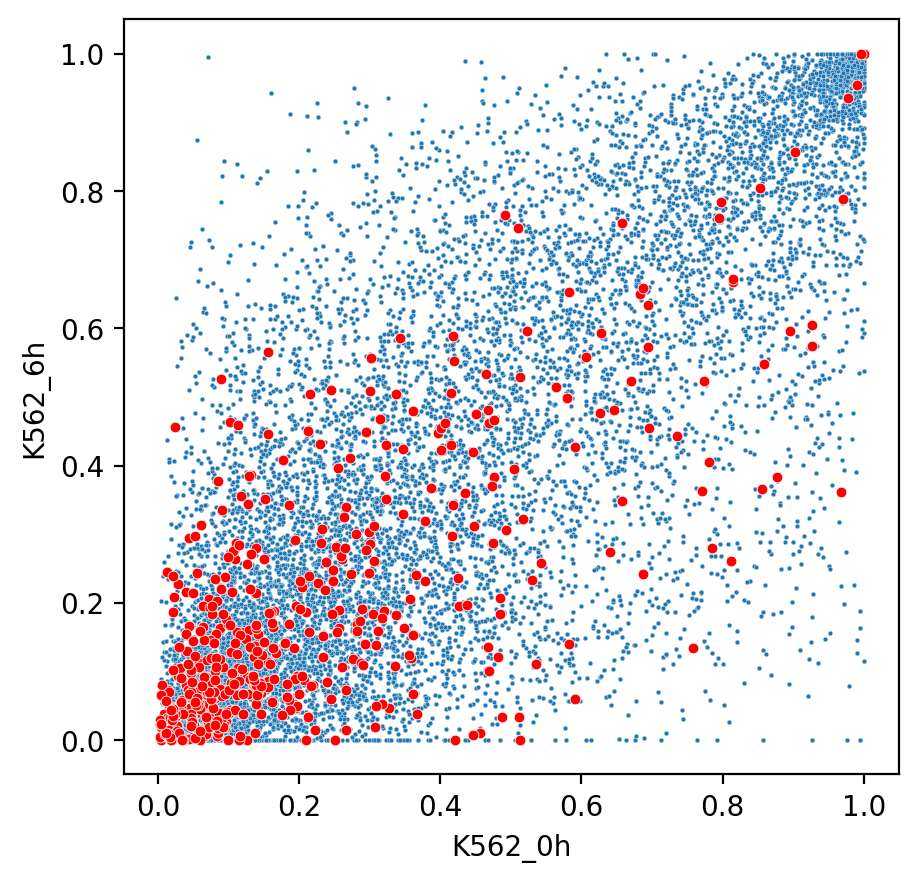

In [114]:
plt.figure(figsize=(5, 5), dpi=200)

sns.scatterplot(x=f"{celline}_0h", y=f"{celline}_6h", data=df_usage[~df_usage['NMD']], s=3)
sns.scatterplot(x=f"{celline}_0h", y=f"{celline}_6h", data=df_usage[df_usage['NMD']], color='red', s=15)

<AxesSubplot:xlabel='K562_2h_dif', ylabel='K562_6h_dif'>

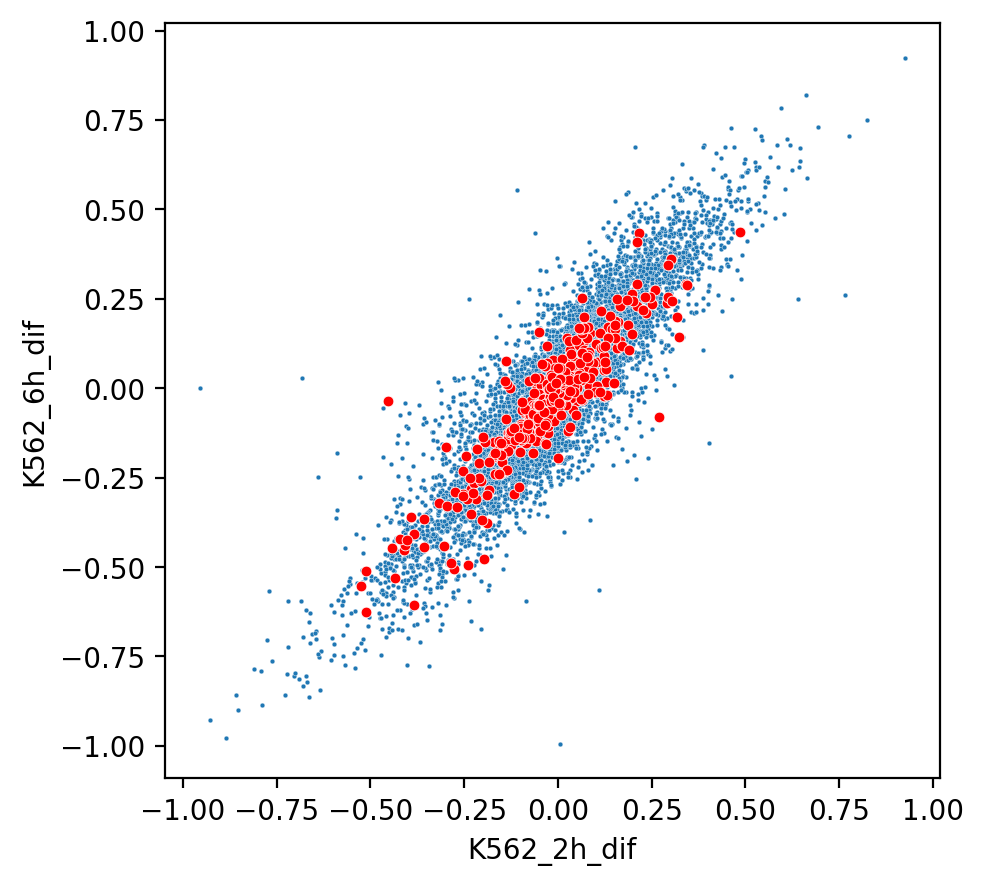

In [115]:
plt.figure(figsize=(5, 5), dpi=200)

sns.scatterplot(x=f"{celline}_2h_dif", y=f"{celline}_6h_dif", data=df_usage[~df_usage['NMD']], s=3)
sns.scatterplot(x=f"{celline}_2h_dif", y=f"{celline}_6h_dif", data=df_usage[df_usage['NMD']], color='red', s=15)

<AxesSubplot:xlabel='K562_0h', ylabel='K562_6h_dif'>

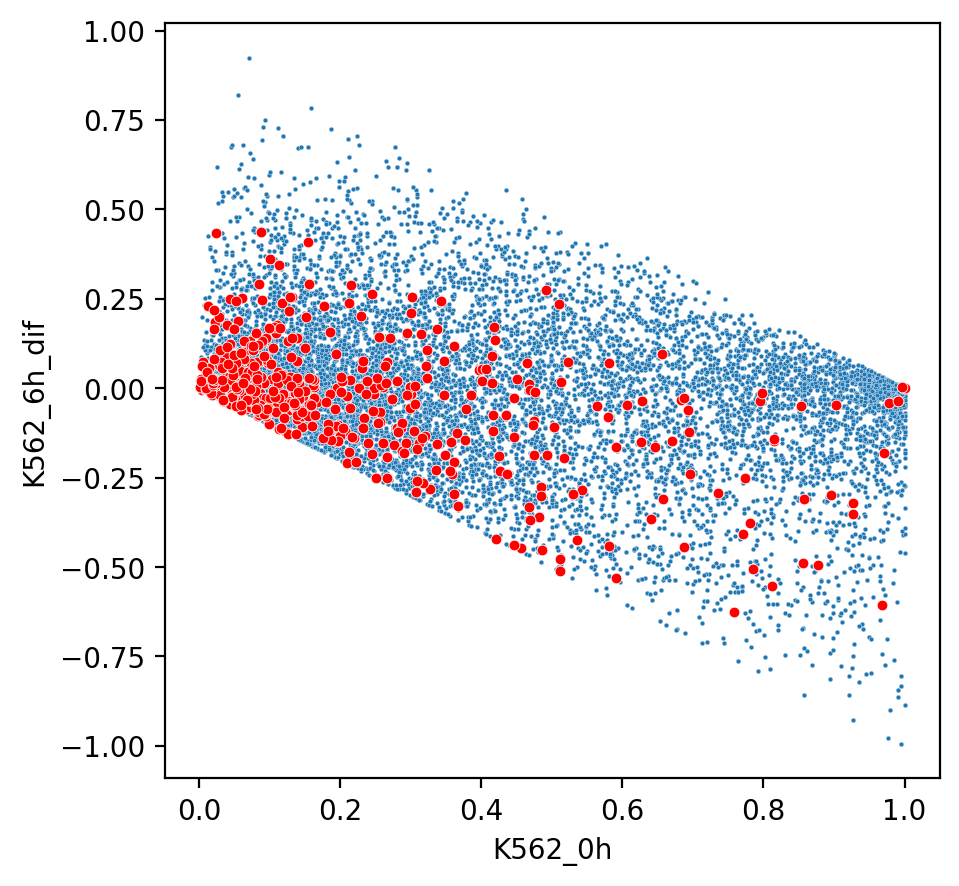

In [116]:
plt.figure(figsize=(5, 5), dpi=200)

sns.scatterplot(x=f"{celline}_0h", y=f"{celline}_6h_dif", data=df_usage[~df_usage['NMD']], s=3)
sns.scatterplot(x=f"{celline}_0h", y=f"{celline}_6h_dif", data=df_usage[df_usage['NMD']], color='red', s=15)

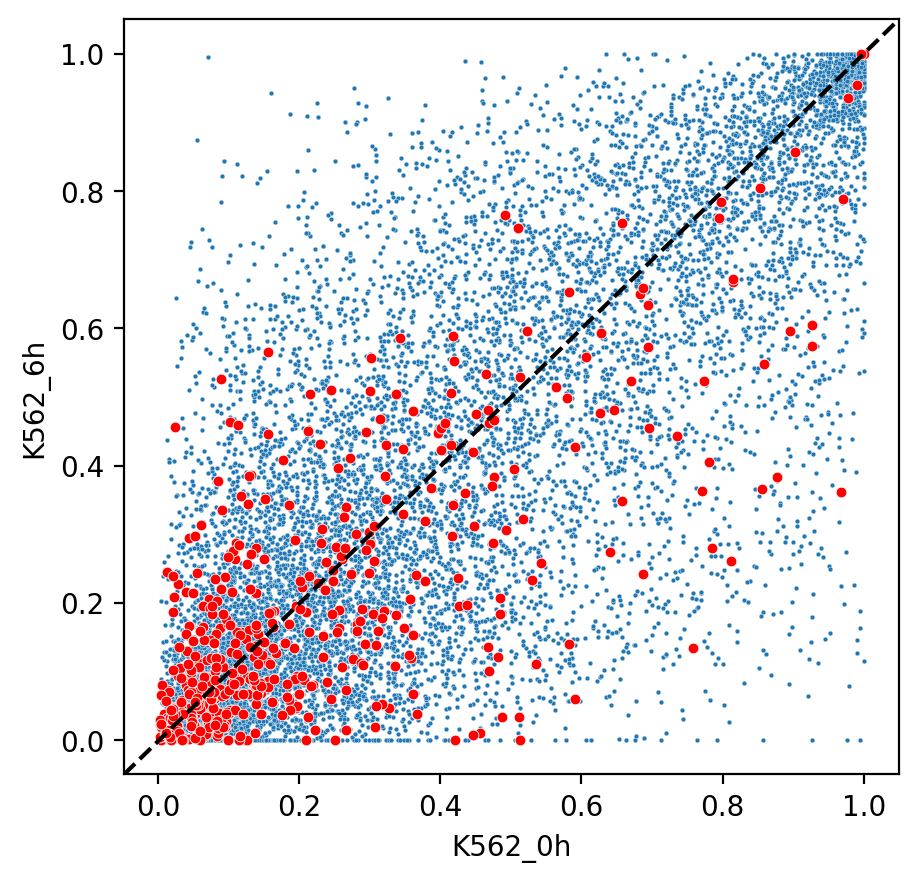

In [117]:
plt.figure(figsize=(5, 5), dpi=200)

sns.scatterplot(x=f"{celline}_0h", y=f"{celline}_6h", data=df_usage[~df_usage['NMD']], s=3)
ax = sns.scatterplot(x=f"{celline}_0h", y=f"{celline}_6h", data=df_usage[df_usage['NMD']], color='red', s=15)
plt.plot([0,1],[0,1], transform=ax.transAxes, color="black", linestyle="--")

In [118]:
df_usage['NMD'] = df_usage['NMD'].astype(str)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.696e-02 U_stat=2.747e+06


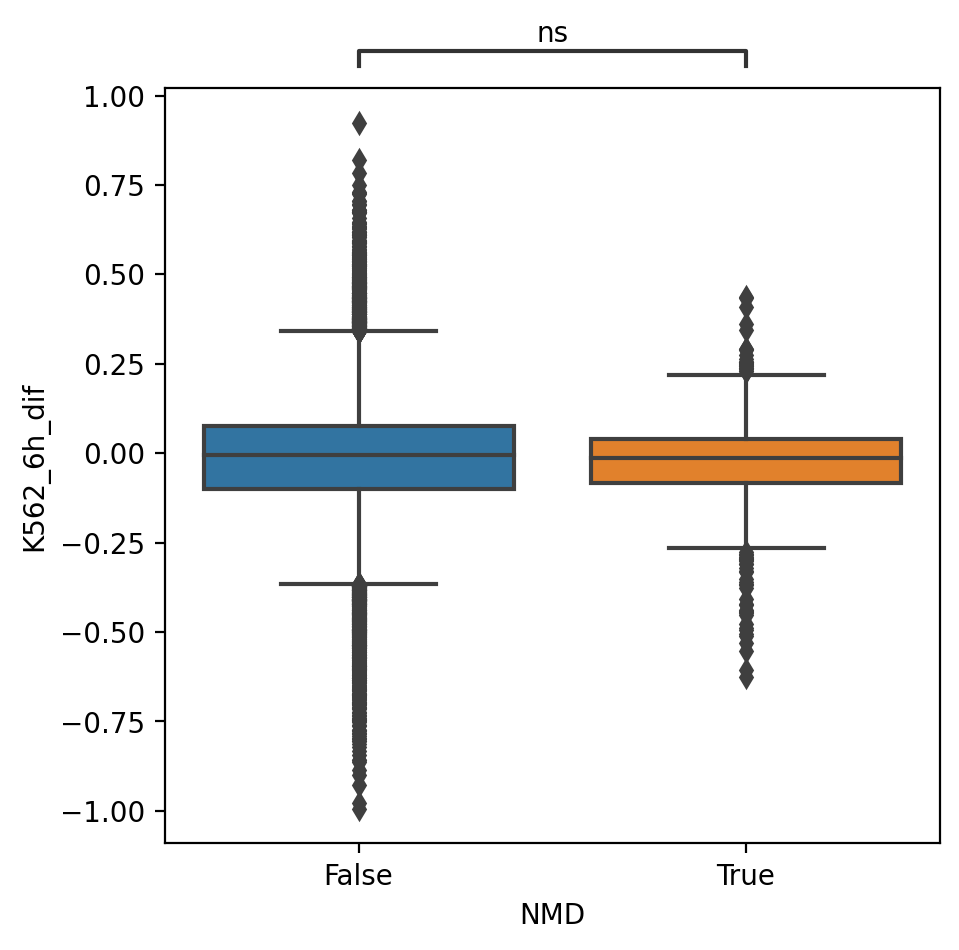

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

plt.figure(figsize=(5, 5), dpi=200)

ax = sns.boxplot(y=f"{celline}_6h_dif", x="NMD", data=df_usage)

annot = Annotator(ax, [('True', 'False')], data=df_usage, y=f"{celline}_6h_dif", x="NMD")
annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
annot.apply_test()
ax, test_results = annot.annotate()


In [148]:
df_abundance = pd.read_csv(snakemake.input['abundance'], sep='\t').set_index('annot_transcript_id')

In [150]:
cell_ab_cols = df_abundance.columns[df_abundance.columns.str.startswith(celline.lower())]

In [155]:
df_ab_cell = df_abundance[cell_ab_cols].sum(axis=1)

In [159]:
df_ab_cell = df_ab_cell[df_ab_cell > 0]

In [163]:
tpm_ab_cell = df_ab_cell / (df_ab_cell.sum() / 1_000_000)

In [170]:
tpm_bru = df_counts[sample_cols].sum(axis=1)
tpm_bru = tpm_bru / (tpm_bru.sum(axis=0) / 1_000_000)

In [176]:
df_tpm = tpm_bru.to_frame().join(tpm_ab_cell.to_frame(), lsuffix='talon')

In [191]:
df_tpm = df_tpm[~((df_tpm.isna()) | (df_tpm < 1)).any(axis=1)]

SpearmanrResult(correlation=0.336244790419747, pvalue=0.0)
(0.16604378082437515, 1.6794110115351543e-110)


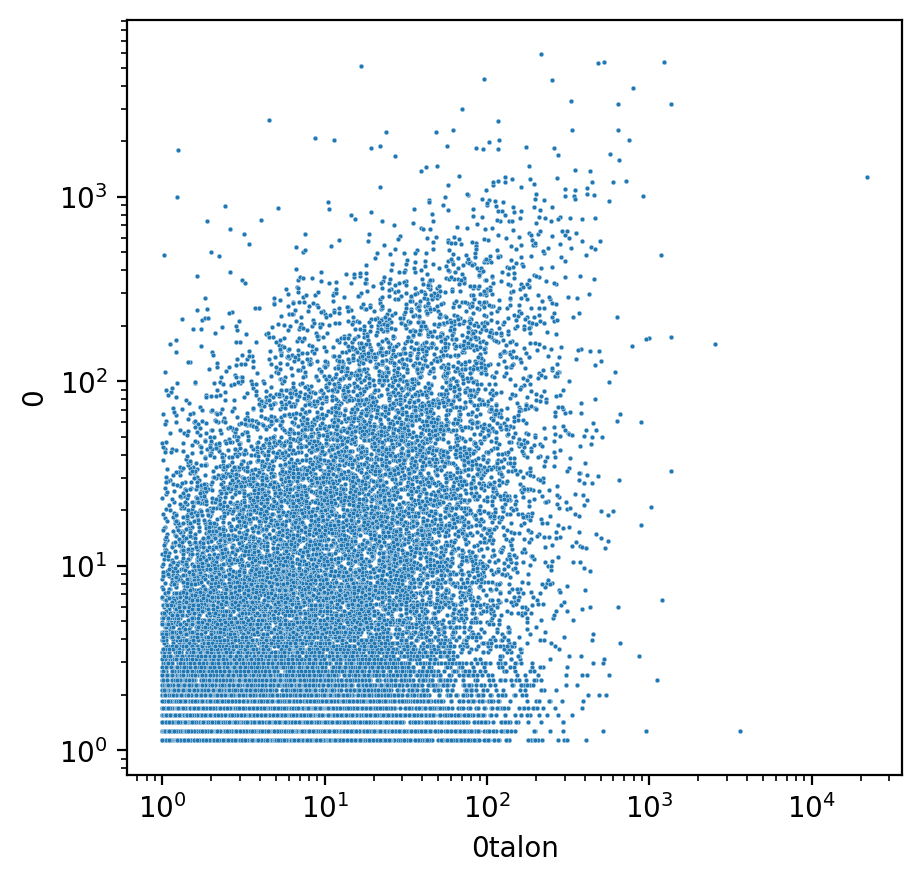

In [209]:
plt.figure(figsize=(5, 5), dpi=200)
from scipy.stats import spearmanr, pearsonr

sns.scatterplot(x="0talon", y='0', data=df_tpm, s=3)

plt.xscale('log')
plt.yscale('log')

print(spearmanr(df_tpm['0talon'], df_tpm['0']))
print(pearsonr(df_tpm['0talon'], df_tpm['0']))

plt.xlabels('Long-read TPM')
plt.xlabels('Brue_TPM')

In [152]:
for i in sample_cols:
    df_usage['r' + i] = df_usage[i] / df_usage[f'{celline}_0h']

In [153]:
sample_cols

['K562_0h', 'K562_2h', 'K562_6h']

Text(0.5, 0, 'time points')

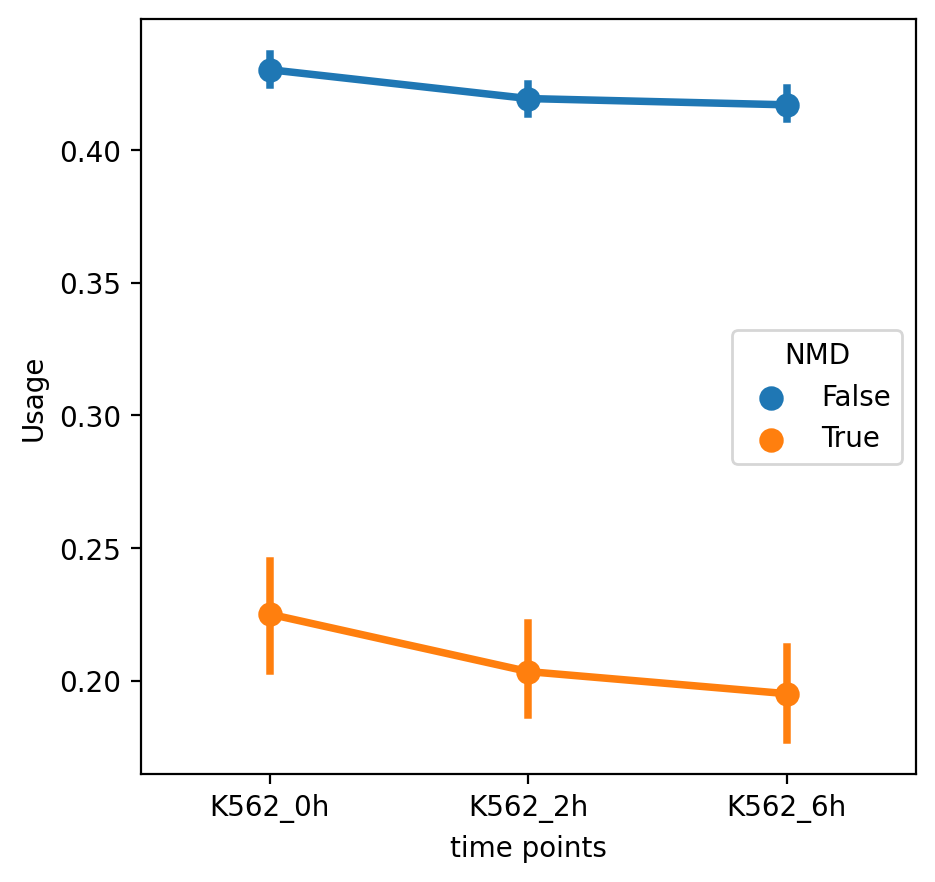

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=200)

r_cols = ['r'+i for i in sample_cols]
sns.pointplot(y="value", x="variable", hue='NMD', data=df_usage[['NMD']+ sample_cols].melt(id_vars=['NMD']))
plt.ylabel('Usage')
plt.xlabel('time points')

Text(0.5, 0, 'time points')

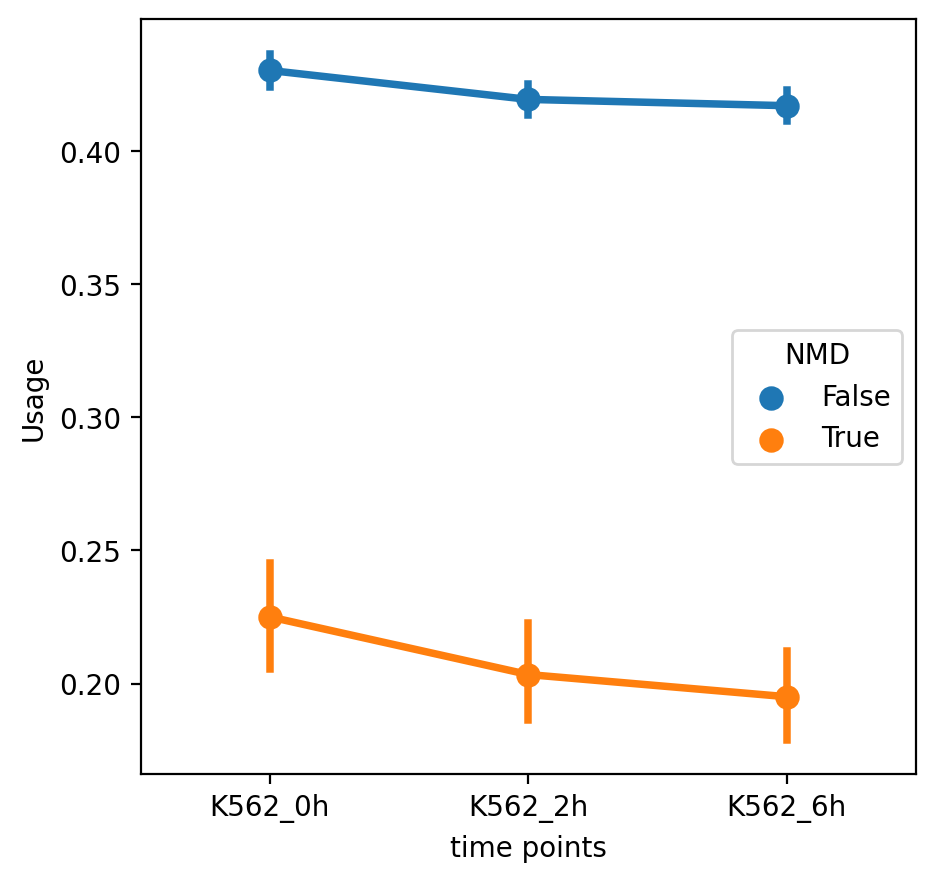

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=200)

sns.pointplot(y="value", x="variable", hue='NMD', data=df_usage[sample_cols + ['NMD']].melt(id_vars=['NMD']))
plt.ylabel('Usage')
plt.xlabel('time points')

In [290]:
# target_transcripts = gr_sample.transcript_id.unique()
# target_genes = gr_sample.gene_id.unique()

In [291]:
# df_usage

In [292]:
# num_transcript = df_usage.groupby('gene_id').size()
# genes = num_transcript[num_transcript > 1].index
#df_usage = df_usage[df_usage['gene_id'].isin(genes)]

In [293]:
# _df_tpm = _df / (_df.sum(axis=0) / 1_000_000)

In [294]:
# _df_tpm = _df_tpm[(_df_tpm > 0).all(axis=1)]
#_df_tpm = _df_tpm[_df_tpm['K562_0h'] > 0]

In [182]:
df_usage['target'] = df_usage.index.isin(target_transcripts)

Text(0.5, 0, 'time points')

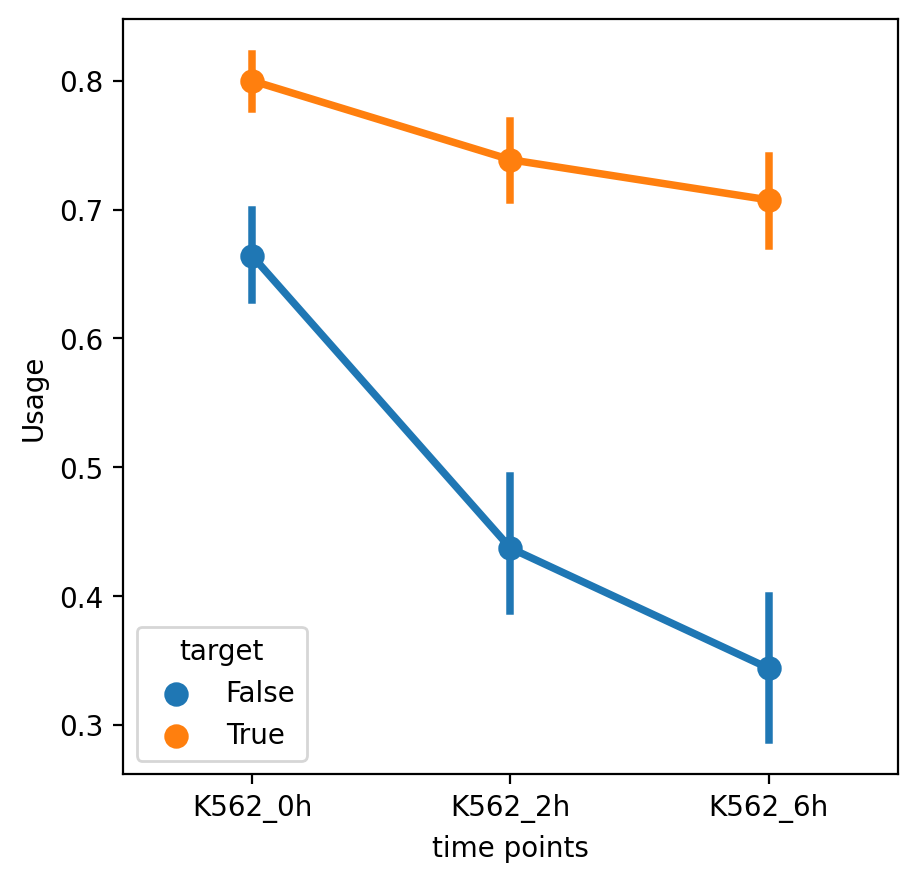

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=200)

sns.pointplot(y="value", x="variable", hue='target', data=df_usage.melt(id_vars=['target', 'gene_id']))
plt.ylabel('Usage')
plt.xlabel('time points')

Text(0.5, 0, 'time points')

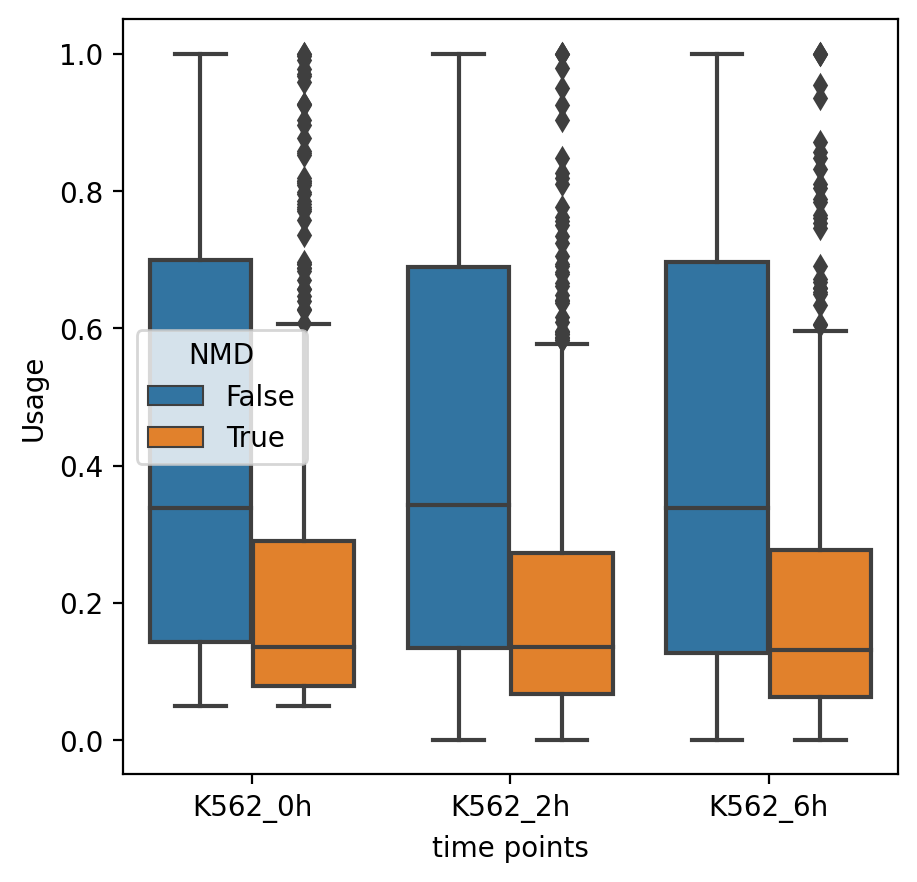

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5), dpi=200)

sns.boxplot(y="value", x="variable", hue='NMD', data=df_usage.melt(id_vars=['NMD', 'gene_id']))
plt.ylabel('Usage')
plt.xlabel('time points')